In [1]:
import numpy as np
import random
import math
import copy
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
# === Load dataset ===

# Load only the CUSTOMER section of the text file
data = pd.read_fwf("rc104.txt", skiprows=8, header=None)
data.columns = ["CUST_NO", "XCOORD", "YCOORD", "DEMAND", "READY_TIME", "DUE_DATE", "SERVICE_TIME"]


# Load data from previous period
data_pre = pd.read_fwf("rc103.txt", skiprows=8, header=None)
data_pre.columns = ["CUST_NO", "XCOORD", "YCOORD", "DEMAND", "READY_TIME", "DUE_DATE", "SERVICE_TIME"]

In [3]:
# === Sets ===
V = list(range(25))  # 25 vehicles
C = list(range(1, len(data)))  # Customers (1 to n), excluding depot (0)
N = list(range(len(data)))  # All nodes including depot
# === Parameters ===
dc = data['DEMAND'].tolist()
dc[0] = 0  # Depot demand = 0
dc_pre = data_pre['DEMAND'].tolist()
dc_pre[0] = 0  # Depot demand = 0
coords = list(zip(data['XCOORD'], data['YCOORD']))
ai = data['READY_TIME'].tolist()
bi = data['DUE_DATE'].tolist()
si = data['SERVICE_TIME'].tolist()

In [4]:
# Problem parameters
cij = 30
delta = 0.17        #https://progresschamber.org/wp-content/uploads/2024/06/Chamber-of-Progress-Efficiency-and-Emissions-Impact-of-Last-Mile-Online-Delivery-in-the-US.pdf
lambda_v = 200
pi = 10
theta = 0.7
mv = 100000
cv = 100
hv = 15
ev = 0.1
cf = 0.5                                                                                        
fv = 0.1
gamma = 0.1
M = 1000000
w1, w2, w3 = 1, 1, 1  # weight for objectives
alpha_w, beta_w, gamma_w = 1, 1, 1  # penalty weights

dc_rev = [round(d * delta) for d in dc_pre]  # Integer reverse demand!!!!

In [5]:
# === Distance matrix ===
t = np.zeros((len(N), len(N)))
for i in N:
    for j in N:
        t[i][j] = math.hypot(coords[i][0] - coords[j][0], coords[i][1] - coords[j][1])

In [6]:
# === Initialize weights and scores ===
destruction_weights = [1.0] * 5
repair_weights = [1.0] * 5
destruction_scores = [0] * 5
repair_scores = [0] * 5
destruction_usage = [1] * 5
repair_usage = [1] * 5
alpha = 0.8  # weight update parameter

In [7]:
# === Roulette Wheel Selection ===
def select_operator(weights):
    total = sum(weights)
    r = random.uniform(0, total)
    cumulative = 0
    for i, w in enumerate(weights):
        cumulative += w
        if r <= cumulative:
            return i
    return len(weights) - 1  # fallback


In [8]:
# === Update Weights ===
def update_weights(weights, scores, usage):
    for i in range(len(weights)):
        weights[i] = alpha * weights[i] + (1 - alpha) * (scores[i] / usage[i] if usage[i] else 0)
        scores[i] = 0
        usage[i] = 1

In [9]:
# === Destruction Operators ===

# 1. Random Destroy Operator
def random_destroy(routes, fraction=0.1):
    all_customers = [(v, cust) for v in range(len(routes)) for cust in routes[v] if cust != 0]
    num_remove = max(1, int(len(all_customers) * fraction))
    to_remove = random.sample(all_customers, num_remove)
    removed = []
    for v, cust in to_remove:
        if cust in routes[v]:
            routes[v].remove(cust)
            removed.append(cust)
    return removed, routes

# 2. Similarity Destroy Operator
def similarity_destroy(routes, coords, q=5):
    def similarity(i, j):
        dist = math.dist(coords[i], coords[j])
        same_route = any(i in r and j in r for r in routes)
        return 1 / (dist + (0 if same_route else 1))
    
    all_customers = [cust for r in routes for cust in r if cust != 0]
    seed = random.choice(all_customers)
    removed = [seed]

    while len(removed) < q:
        curr = random.choice(removed)
        candidates = [c for c in all_customers if c not in removed]
        if not candidates:
            break

        # Sort by similarity
        candidates.sort(key=lambda j: -similarity(curr, j))
                
        # Select a random index with bias toward more similar
        rand_index = int(random.random() * len(candidates))  # like floor(rand * |L|)
        selected = candidates[rand_index]

        removed.append(selected)

    # Remove selected customers from routes
    for v in range(len(routes)):
        routes[v] = [c for c in routes[v] if c not in removed]

    return removed, routes

# 3. Maximum Saving Cost Destroy Operator
def max_saving_destroy(routes, coords, q=5):
    savings = []
    for v, route in enumerate(routes):
        for i in range(1, len(route) - 1):
            prev, curr, next_ = route[i-1], route[i], route[i+1]
            saving = t[prev][curr] + t[curr][next_] - t[prev][next_]
            savings.append((saving, v, curr))
    savings.sort(reverse=True)
    removed = [cust for _, v, cust in savings[:q]]
    for _, v, cust in savings[:q]:
        routes[v].remove(cust)
    return removed, routes

# 4. Destroying Vehicle Destroy Operator
def destroying_vehicle_destroy(routes):
    max_cost = -1
    vehicle_to_remove = -1
    for v, route in enumerate(routes):
        if not route: continue
        cost = sum(t[route[i]][route[i+1]] for i in range(len(route) - 1))
        if cost > max_cost:
            max_cost = cost
            vehicle_to_remove = v
    removed = [cust for cust in routes[vehicle_to_remove] if cust != 0]
    routes[vehicle_to_remove] = []
    return removed, routes

# 5. Maximum Waiting Time Destroy Operator (simplified)
def max_waiting_time_destroy(routes, ai, si):
    def calc_wait(route):
        time = 0
        wait_total = 0
        for i in range(1, len(route)):
            travel = t[route[i-1]][route[i]]
            time += travel
            if route[i] != 0:
                wait = max(0, ai[route[i]] - time)
                wait_total += wait
                time += si[route[i]]
        return wait_total
    vehicle_to_remove = max(range(len(routes)), key=lambda v: calc_wait(routes[v]))
    removed = [cust for cust in routes[vehicle_to_remove] if cust != 0]
    routes[vehicle_to_remove] = []
    return removed, routes

destruction_ops = [
    lambda r: random_destroy(r, fraction=0.1),
    lambda r: similarity_destroy(r, coords, q=5),
    lambda r: max_saving_destroy(r, coords, q=5),
    lambda r: max_waiting_time_destroy(r, ai, si),
    lambda r: destroying_vehicle_destroy(r)
]

In [10]:
# === Repair Operators ===

# 1. Global Optimal Repair Operator
def global_optimal_repair(routes, removed):
    for cust in removed:
        best_cost = float('inf')
        best_pos = None
        for v, route in enumerate(routes):
            for i in range(1, len(route)):
                if not is_time_window_feasible(route, i, cust, ai, bi, si, t):
                    continue
                temp = copy.deepcopy(routes)
                temp[v].insert(i, cust)
                cost_value = evaluate_with_penalty(temp)[0]
                if cost_value < best_cost:
                    best_cost = cost_value
                    best_pos = (v, i)
        if best_pos:
            v, i = best_pos
            routes[v].insert(i, cust)
        else:
            routes.append([0, cust, 0])
    return routes


# 2. Minimum Insertion Cost Repair Operator
def min_insertion_cost_repair(routes, removed):
    for cust in removed:
        best_cost = float('inf')
        best_pos = None
        for v, route in enumerate(routes):
            for i in range(1, len(route)):
                if not is_time_window_feasible(route, i, cust, ai, bi, si, t):
                    continue
                temp = copy.deepcopy(routes)
                temp[v].insert(i, cust)
                cost_value = evaluate_with_penalty(temp)[0]
                if cost_value < best_cost:
                    best_cost = cost_value
                    best_pos = (v, i)
        if best_pos:
            v, i = best_pos
            routes[v].insert(i, cust)
        else:
            routes.append([0, cust, 0])
    return routes


# 3. Random K Repair Operator
def random_k_repair(routes, removed, k=3):
    for cust in removed:
        candidates = []
        for v, route in enumerate(routes):
            for i in range(1, len(route)):
                if not is_time_window_feasible(route, i, cust, ai, bi, si, t):
                    continue
                temp = copy.deepcopy(routes)
                temp[v].insert(i, cust)
                cost_value = evaluate_with_penalty(temp)[0]
                candidates.append((cost_value, v, i))
        if candidates:
            candidates.sort()
            _, v, i = random.choice(candidates[:min(k, len(candidates))])
            routes[v].insert(i, cust)
        else:
            routes.append([0, cust, 0])
    return routes

# 4. Regret Criterion Repair Operator
def regret_repair(routes, removed, k=3):
    while removed:
        regrets = []
        for cust in removed:
            costs = []
            for v, route in enumerate(routes):
                for i in range(1, len(route)):
                    if not is_time_window_feasible(route, i, cust, ai, bi, si, t):
                        continue
                    temp = copy.deepcopy(routes)
                    temp[v].insert(i, cust)
                    cost_value = evaluate_with_penalty(temp)[0]
                    costs.append(cost_value)
            if len(costs) >= k:
                costs.sort()
                regret = sum(costs[j] - costs[0] for j in range(1, k))
                regrets.append((regret, cust))
        if regrets:
            regrets.sort(reverse=True)
            _, chosen = regrets[0]
            removed.remove(chosen)
            routes = global_optimal_repair(routes, [chosen])
        else:
            break
    return routes


# 5. Minimum Waiting Time Repair Operator
def min_waiting_time_repair(routes, removed, ai, si):
    for cust in removed:
        min_wait = float('inf')
        best_pos = None
        for v, route in enumerate(routes):
            time = 0
            for i in range(1, len(route)):
                if not is_time_window_feasible(route, i, cust, ai, bi, si, t):
                    continue
                prev = route[i - 1]
                curr = route[i]
                time += t[prev][curr] + (si[curr] if curr != 0 else 0)
                arrival = time + t[prev][cust]
                wait = max(0, ai[cust] - arrival)

                temp = copy.deepcopy(routes)
                temp[v].insert(i, cust)
                penalty = evaluate_with_penalty(temp)[1]
                if wait < min_wait:
                    min_wait = wait
                    best_pos = (v, i)
        if best_pos:
            v, i = best_pos
            routes[v].insert(i, cust)
        else:
            routes.append([0, cust, 0])
    return routes


repair_ops = [
    lambda r, rem: global_optimal_repair(r, rem),
    lambda r, rem: min_insertion_cost_repair(r, rem),
    lambda r, rem: regret_repair(r, rem, k=3),
    lambda r, rem: random_k_repair(r, rem, k=3),
    lambda r, rem: min_waiting_time_repair(r, rem, ai, si)
]

In [11]:
# === 1. Nearest Neighbor Heuristic ===
def nearest_neighbor_initial_solution():
    unvisited = set(C)
    routes = [[] for _ in V]
    v = 0

    while unvisited:
        if v >= len(V):
            raise RuntimeError("Insufficient vehicles.")
        route = [0]
        load = 0
        curr = 0
        while True:
            nearest = None
            nearest_dist = float('inf')
            for cust in unvisited:
                if dc[cust] + load <= lambda_v and t[curr][cust] < nearest_dist:
                    nearest = cust
                    nearest_dist = t[curr][cust]
            if nearest is None:
                break
            route.append(nearest)
            load += dc[nearest]
            curr = nearest
            unvisited.remove(nearest)
        route.append(0)
        routes[v] = route
        v += 1
    return routes
initial_routes = nearest_neighbor_initial_solution()

import json
with open("routes_nns.json", "w") as f:
    json.dump(initial_routes, f)

    # Preview output
for v, route in enumerate(initial_routes):
    if route:
        print(f"Vehicle {v}: {route}")

Vehicle 0: [0, 90, 65, 66, 83, 64, 56, 95, 92, 91, 80, 94, 93, 71, 96, 0]
Vehicle 1: [0, 69, 98, 53, 88, 55, 100, 70, 68, 61, 81, 54, 72, 41, 39, 62, 0]
Vehicle 2: [0, 82, 99, 52, 57, 86, 74, 87, 59, 97, 75, 58, 77, 85, 0]
Vehicle 3: [0, 67, 50, 34, 31, 29, 27, 26, 28, 30, 32, 33, 63, 73, 0]
Vehicle 4: [0, 60, 78, 12, 14, 47, 17, 16, 15, 13, 9, 24, 20, 0]
Vehicle 5: [0, 84, 51, 76, 89, 18, 48, 21, 23, 25, 49, 0]
Vehicle 6: [0, 2, 6, 7, 8, 46, 4, 45, 5, 3, 1, 44, 0]
Vehicle 7: [0, 10, 11, 79, 42, 43, 40, 36, 0]
Vehicle 8: [0, 22, 19, 38, 37, 35, 0]


In [12]:
# === a Feasibility Checker Function ===
def is_time_window_feasible(route, insert_pos, cust, ai, bi, si, t):
    prev = route[insert_pos - 1]
    next_ = route[insert_pos] if insert_pos < len(route) else 0

    # Estimate earliest possible arrival at 'cust'
    est = max(ai[cust], ai[prev] + si[prev] + t[prev][cust])
    lst = bi[cust]

    # Check if insertion affects the next node's feasibility
    if next_ != 0:
        latest_next = bi[next_] - t[cust][next_] - si[cust]
        if est > latest_next:
            return False

    return est <= lst

# === Evaluation F(X) + penalty(X) with Forward/Backward Slack for Time Windows ===
def evaluate_with_penalty(routes):
    total_cost = 0
    Feco = Fenv = Fsoc = 0
    unmet_delivery = {i: dc[i] for i in C}
    unmet_return = {i: dc_rev[i] for i in C}

    violation_penalty = 0
    penalty_tw_total = 0
    penalty_capacity_total = 0
    penalty_mv_total = 0

    for route in routes:
        if len(route) < 2:
            continue

        time = 0
        capacity = lambda_v

        # Forward pass for earliest start times
        esi = {route[0]: 0}
        for i in range(1, len(route)):
            prev = route[i - 1]
            curr = route[i]
            travel = t[prev][curr]
            arrival = esi[prev] + si[prev] + travel
            esi[curr] = max(arrival, ai[curr])

        # Backward pass for latest start times
        lsi = {route[-1]: float('inf')}
        for i in reversed(range(len(route) - 1)):
            curr = route[i]
            succ = route[i + 1]
            travel = t[curr][succ]
            latest = lsi[succ] - si[curr] - travel
            lsi[curr] = min(latest, bi[curr])

        for i in range(1, len(route) - 1):
            curr = route[i]
            est = esi[curr]
            lst = lsi[curr]

            penalty_tw = max(0, ai[curr] - est) + max(0, est - bi[curr])
            penalty_tw_total += 1e3 * penalty_tw

            deliver = min(unmet_delivery[curr], capacity)
            capacity -= deliver
            unmet_delivery[curr] -= deliver

            reverse = min(unmet_return[curr], capacity)
            capacity -= reverse
            unmet_return[curr] -= reverse

            if deliver + reverse > lambda_v or capacity < 0:
                penalty_capacity_total += 1e6

        route_time = esi[route[-1]]
        if route_time > mv:
            penalty_mv_total += 1e6

        route_feco = cv + hv * route_time + sum(t[route[i]][route[i+1]] * (cf * fv + cij) for i in range(len(route) - 1))
        route_fenv = sum(t[route[i]][route[i+1]] * ev * gamma for i in range(len(route) - 1))
        route_fsoc = route_time * hv

        Feco += route_feco
        Fenv += route_fenv
        Fsoc += route_fsoc

    Feco += pi * (sum(unmet_delivery[i] for i in C) + (1 - theta) * sum(unmet_return[i] for i in C))

    violation_penalty = penalty_tw_total + penalty_capacity_total + penalty_mv_total
    total_cost = Feco + Fenv + Fsoc + violation_penalty

    return total_cost, violation_penalty, penalty_tw_total, penalty_capacity_total, penalty_mv_total


In [13]:
# === Main IALNS-SA ===
def ialns_sa(initial_routes, evaluate_func, destruction_ops, repair_ops, T0=1000, Tmin=1, cooling_rate=0.995, max_iter = 1000):
    current = copy.deepcopy(initial_routes)
    best = copy.deepcopy(current)
    best_cost, *_ = evaluate_func(best)
    temperature = T0
    objective_progress = []
    time_progress = []
    start_time = time.time()

    for it in range(max_iter):
        d_idx = select_operator(destruction_weights)
        r_idx = select_operator(repair_weights)

        removed, destroyed = destruction_ops[d_idx](copy.deepcopy(current))
        repaired = repair_ops[r_idx](copy.deepcopy(destroyed), removed)

        new_cost, *_ = evaluate_func(repaired)
        delta = new_cost - best_cost

        if delta < 0 or random.random() < math.exp(-delta / temperature):
            current = copy.deepcopy(repaired)
            if new_cost < best_cost:
                best = copy.deepcopy(repaired)
                best_cost = new_cost
                destruction_scores[d_idx] += 6
                repair_scores[r_idx] += 6
            else:
                destruction_scores[d_idx] += 3
                repair_scores[r_idx] += 3
        else:
            destruction_scores[d_idx] += 0
            repair_scores[r_idx] += 0

        destruction_usage[d_idx] += 1
        repair_usage[r_idx] += 1

        if it % 100 == 0:
            update_weights(destruction_weights, destruction_scores, destruction_usage)
            update_weights(repair_weights, repair_scores, repair_usage)

        temperature = max(Tmin, temperature * cooling_rate)

        if it % 100 == 0:
            print(f"Iter {it}: Best cost = {best_cost:.2f}, Temp = {temperature:.2f}")

        if it % 1 == 0:  # store every iteration
            objective_progress.append(best_cost)
            time_progress.append(time.time() - start_time)

    return best, best_cost, objective_progress, time_progress

In [14]:
initial_cost, *_ = evaluate_with_penalty(initial_routes)
print("\nInitial Solution (NNS):")
for v, r in enumerate(initial_routes):
    if r: print(f"Vehicle {v}: {r}")
print(f"Initial Cost: {initial_cost:.2f}\n")

lns_routes, lns_cost, _, _ = ialns_sa(
    initial_routes, evaluate_with_penalty, destruction_ops, repair_ops
)

print("\nFinal Solution (IALNS-SA):")
for v, r in enumerate(lns_routes):
    if r: print(f"Vehicle {v}: {r}")
print(f"Final Cost: {lns_cost:.2f}")

final_cost, penalty_final, penalty_tw, penalty_cap, penalty_mv = evaluate_with_penalty(lns_routes)
print(f"  penalty tw: {penalty_tw:.2f}, penalty_cap: {penalty_cap:.2f}, penalty_mv: {penalty_mv:.2f}, Penalty: {penalty_final:.2f}")


Initial Solution (NNS):
Vehicle 0: [0, 90, 65, 66, 83, 64, 56, 95, 92, 91, 80, 94, 93, 71, 96, 0]
Vehicle 1: [0, 69, 98, 53, 88, 55, 100, 70, 68, 61, 81, 54, 72, 41, 39, 62, 0]
Vehicle 2: [0, 82, 99, 52, 57, 86, 74, 87, 59, 97, 75, 58, 77, 85, 0]
Vehicle 3: [0, 67, 50, 34, 31, 29, 27, 26, 28, 30, 32, 33, 63, 73, 0]
Vehicle 4: [0, 60, 78, 12, 14, 47, 17, 16, 15, 13, 9, 24, 20, 0]
Vehicle 5: [0, 84, 51, 76, 89, 18, 48, 21, 23, 25, 49, 0]
Vehicle 6: [0, 2, 6, 7, 8, 46, 4, 45, 5, 3, 1, 44, 0]
Vehicle 7: [0, 10, 11, 79, 42, 43, 40, 36, 0]
Vehicle 8: [0, 22, 19, 38, 37, 35, 0]
Initial Cost: 2217559.49

Iter 0: Best cost = 2217559.49, Temp = 995.00
Iter 100: Best cost = 903907.75, Temp = 602.74
Iter 200: Best cost = 725482.98, Temp = 365.12
Iter 300: Best cost = 621771.90, Temp = 221.18
Iter 400: Best cost = 460612.26, Temp = 133.98
Iter 500: Best cost = 445126.17, Temp = 81.16
Iter 600: Best cost = 443195.16, Temp = 49.17
Iter 700: Best cost = 439578.86, Temp = 29.78
Iter 800: Best cost = 4

In [15]:
destruction_op_names = ['Random Destroy', 'Similarity Destroy', 'Max Saving Destroy', 'Max Wait Destroy', 'Destroy Route']
repair_op_names = ['Global Optimal Repair', 'Min Insertion Cost', 'Regret Repair', 'Random-k Repair', 'Min Waiting Time']

# Operator usage summary
print("\n=== Operator Usage Summary ===")

print("\nDestruction Operators Usage:")
for idx, count in enumerate(destruction_usage):
    print(f"  D{idx+1} - {destruction_op_names[idx]}: used {count} times")

print("\nRepair Operators Usage:")
for idx, count in enumerate(repair_usage):
    print(f"  R{idx+1} - {repair_op_names[idx]}: used {count} times")




=== Operator Usage Summary ===

Destruction Operators Usage:
  D1 - Random Destroy: used 14 times
  D2 - Similarity Destroy: used 38 times
  D3 - Max Saving Destroy: used 46 times
  D4 - Max Wait Destroy: used 3 times
  D5 - Destroy Route: used 3 times

Repair Operators Usage:
  R1 - Global Optimal Repair: used 26 times
  R2 - Min Insertion Cost: used 38 times
  R3 - Regret Repair: used 31 times
  R4 - Random-k Repair: used 5 times
  R5 - Min Waiting Time: used 4 times


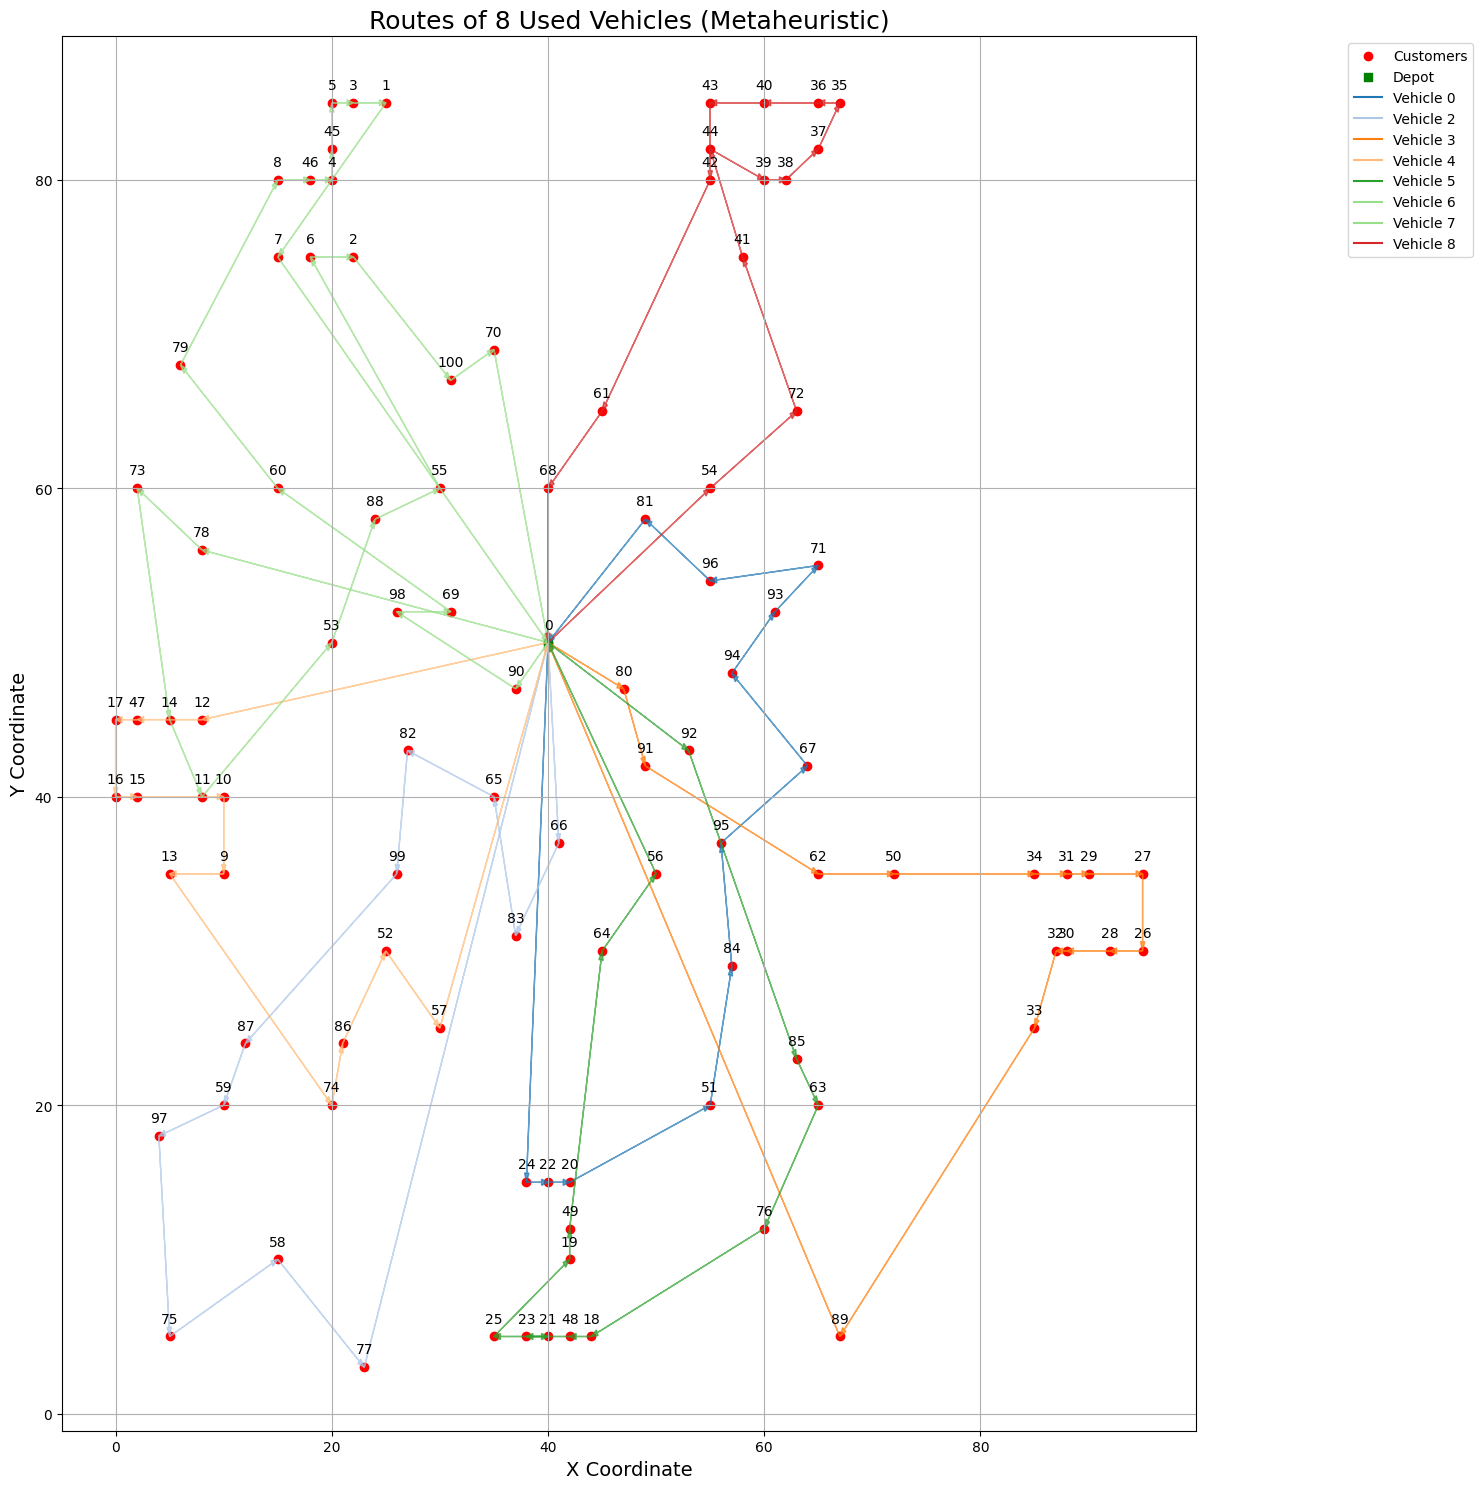

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_metaheuristic_routes(routes, coords, V):
    # Extract X and Y coordinates
    xc = [c[0] for c in coords]
    yc = [c[1] for c in coords]

    plt.figure(figsize=(15, 15))
    plt.scatter(xc, yc, c='red', label='Customers')
    plt.scatter(xc[0], yc[0], c='green', marker='s', label='Depot')

    for i, (x, y_) in enumerate(zip(xc, yc)):
        plt.annotate(str(i), (x, y_), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10)

    cmap = plt.get_cmap('tab20', len(V))
    used_vehicle_count = 0

    for v, route in enumerate(routes):
        if not route or len(route) < 2:
            continue
        used_vehicle_count += 1
        color = cmap(v % 20)

        for i in range(len(route) - 1):
            a, b = route[i], route[i + 1]
            plt.arrow(xc[a], yc[a], xc[b] - xc[a], yc[b] - yc[a],
                      color=color, head_width=0.4, length_includes_head=True, alpha=0.7)

        plt.plot([], [], color=color, label=f'Vehicle {v}')

    plt.xlabel('X Coordinate', fontsize=14)
    plt.ylabel('Y Coordinate', fontsize=14)
    plt.title(f'Routes of {used_vehicle_count} Used Vehicles (Metaheuristic)', fontsize=18)
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
plot_metaheuristic_routes(lns_routes, coords, V)


In [17]:
import matplotlib.pyplot as plt

def plot_forward_reverse_meta(routes, dc, dc_rev, lambda_v):
    for v, route in enumerate(routes):
        if not route or len(route) < 3:
            continue  # Skip empty or trivial routes

        fwd_qty = []
        rev_qty = []
        cap = lambda_v
        cust_nodes = []

        for i in range(1, len(route) - 1):  # exclude depot at start/end
            node = route[i]
            forward = min(dc[node], cap)
            cap -= forward
            reverse = min(dc_rev[node], cap)
            cap -= reverse

            fwd_qty.append(forward)
            rev_qty.append(reverse)
            cust_nodes.append(str(node))  # for x-axis

        plt.figure(figsize=(12, 5))
        plt.plot(cust_nodes, fwd_qty, marker='o', label='Forward Quantity (Fc)', color='blue')
        plt.plot(cust_nodes, rev_qty, marker='s', label='Reverse Quantity (Rc)', color='orange')
        plt.axhline(y=lambda_v, color='gray', linestyle='--', label=f'Capacity {lambda_v}', alpha=0.5)

        # Annotate points
        for idx, val in enumerate(fwd_qty):
            plt.text(cust_nodes[idx], val, f'{val:.1f}', ha='center', va='bottom', fontsize=9, color='blue')
        for idx, val in enumerate(rev_qty):
            plt.text(cust_nodes[idx], val, f'{val:.1f}', ha='center', va='top', fontsize=9, color='orange')

        plt.title(f'Forward and Reverse Quantities - Vehicle {v}', fontsize=14)
        plt.xlabel('Customer Node', fontsize=12)
        plt.ylabel('Quantity', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


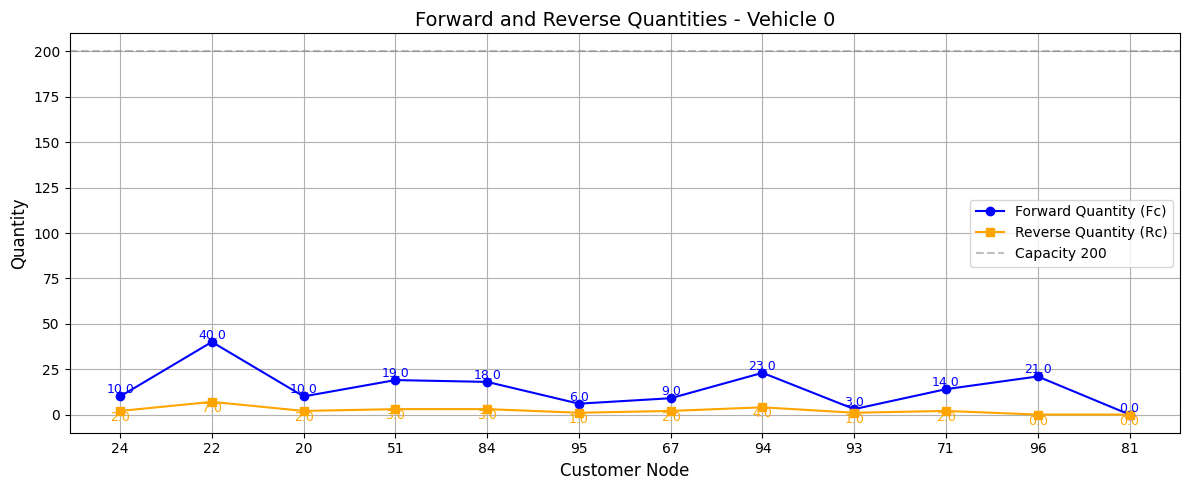

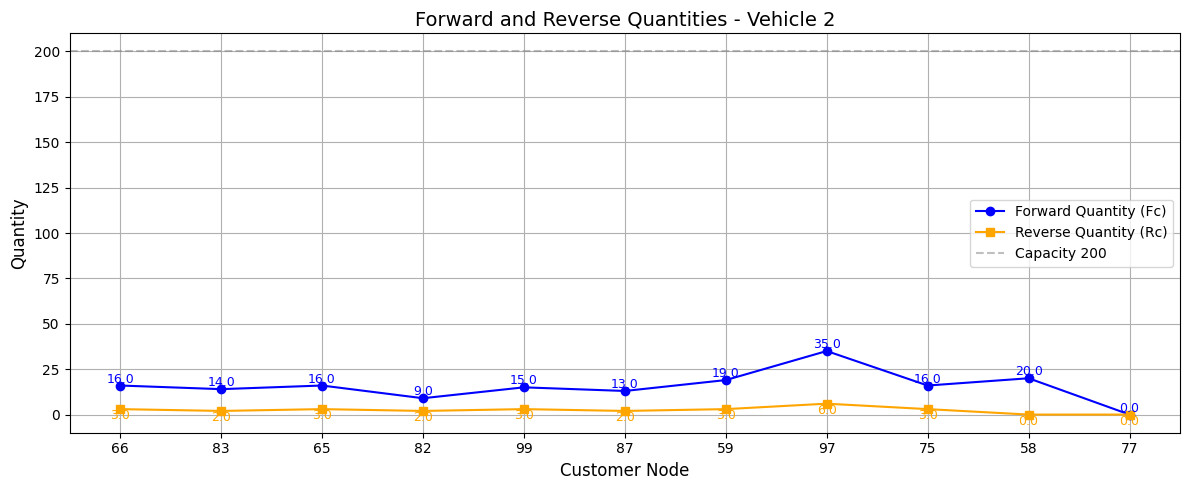

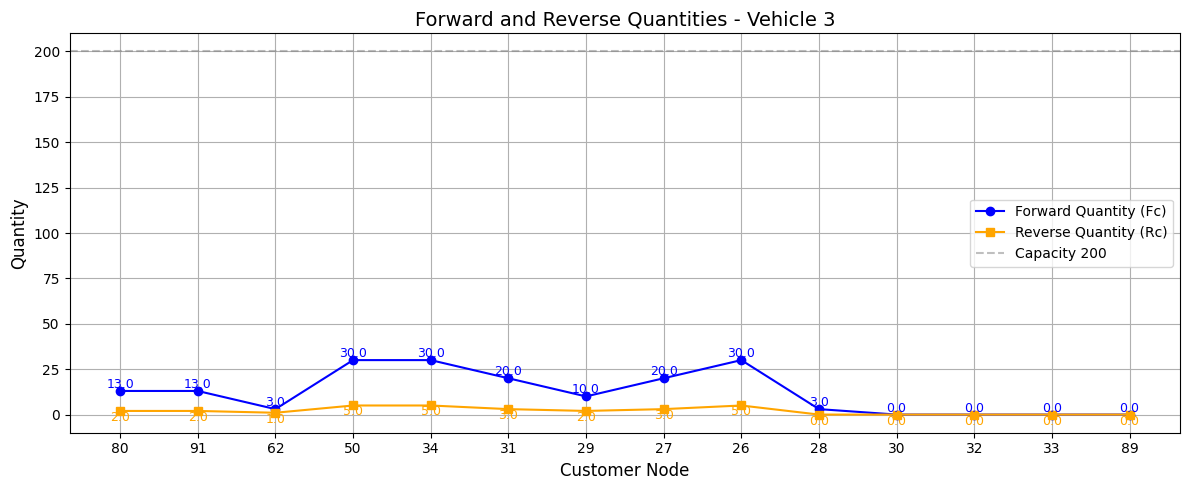

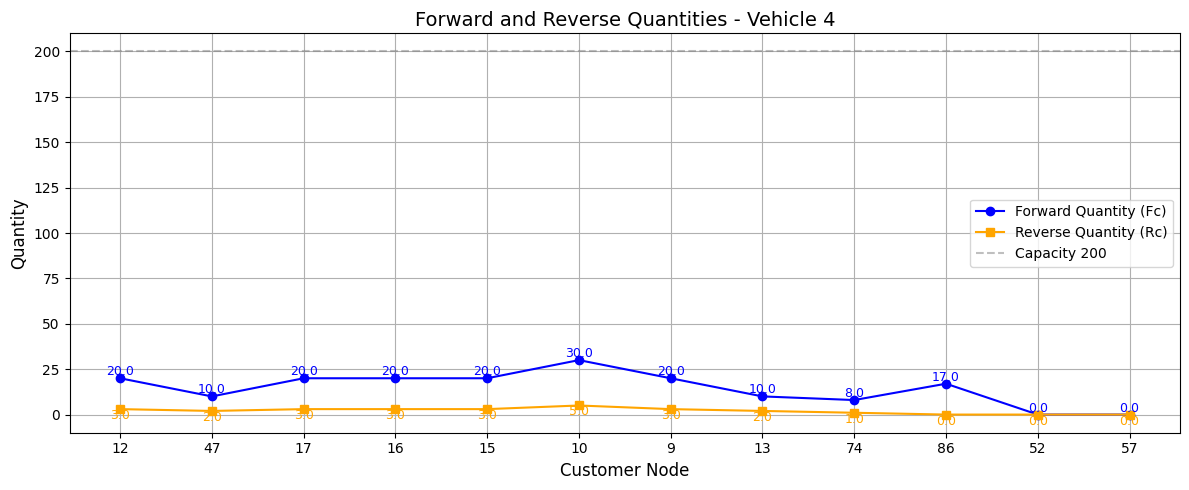

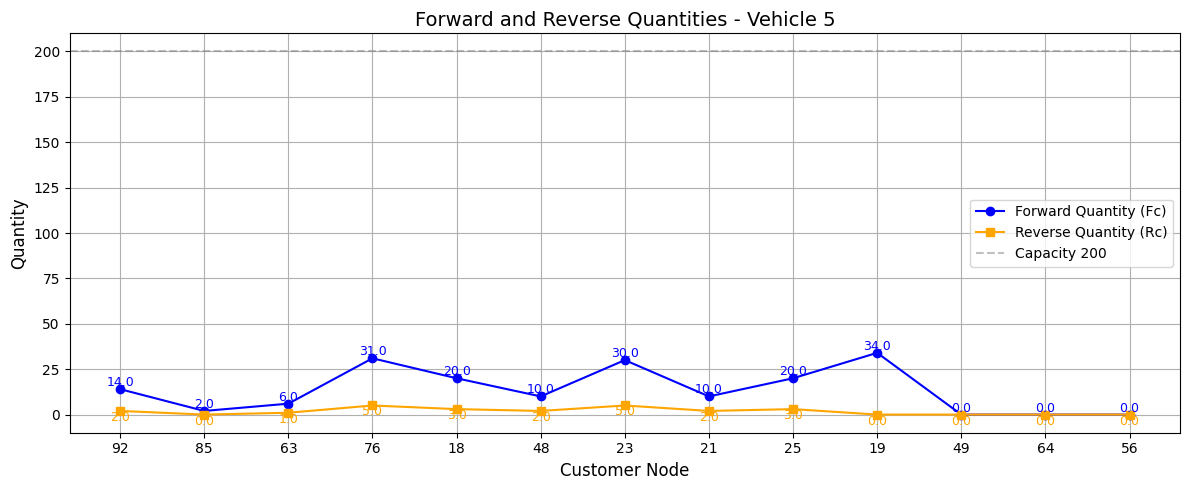

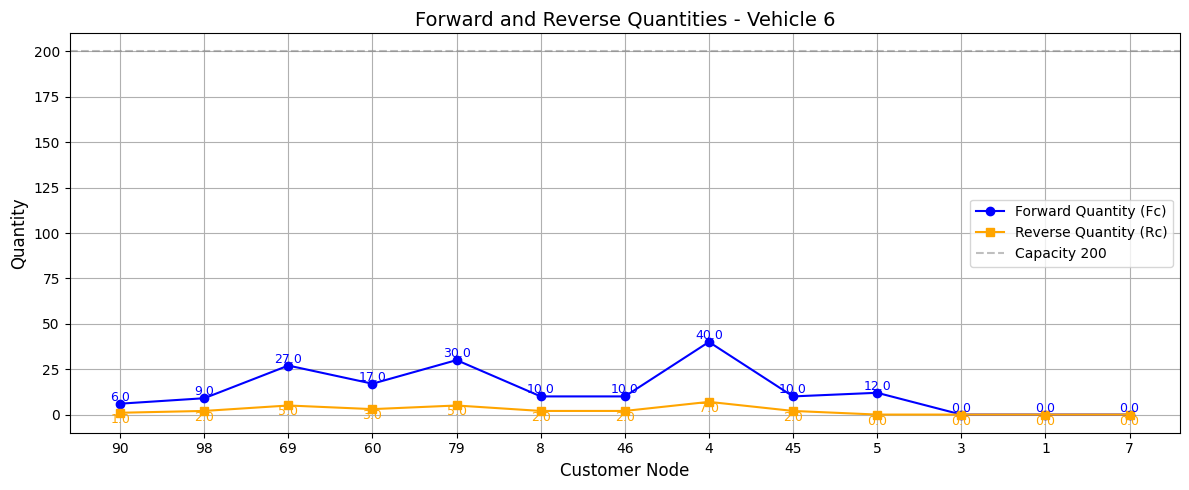

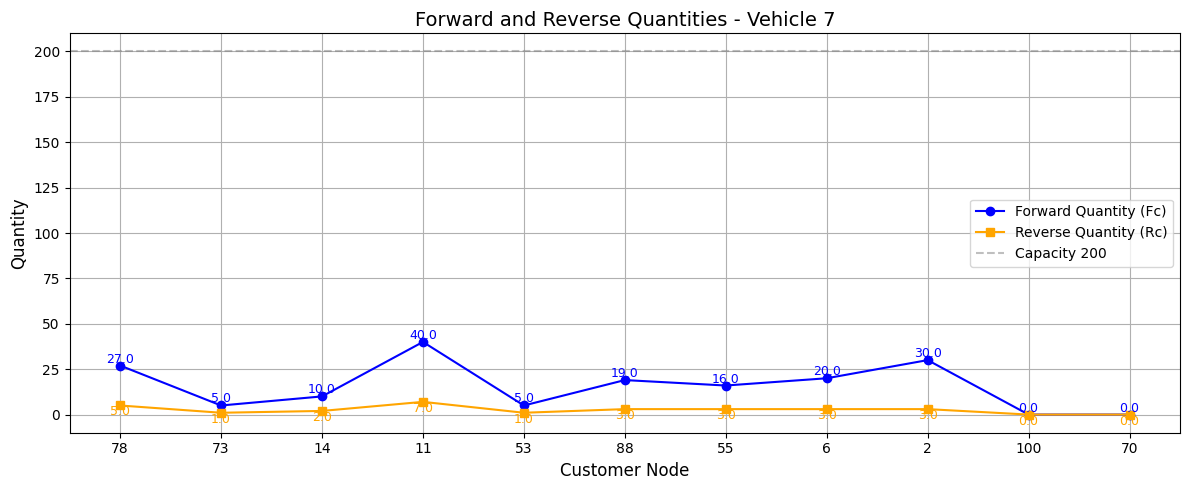

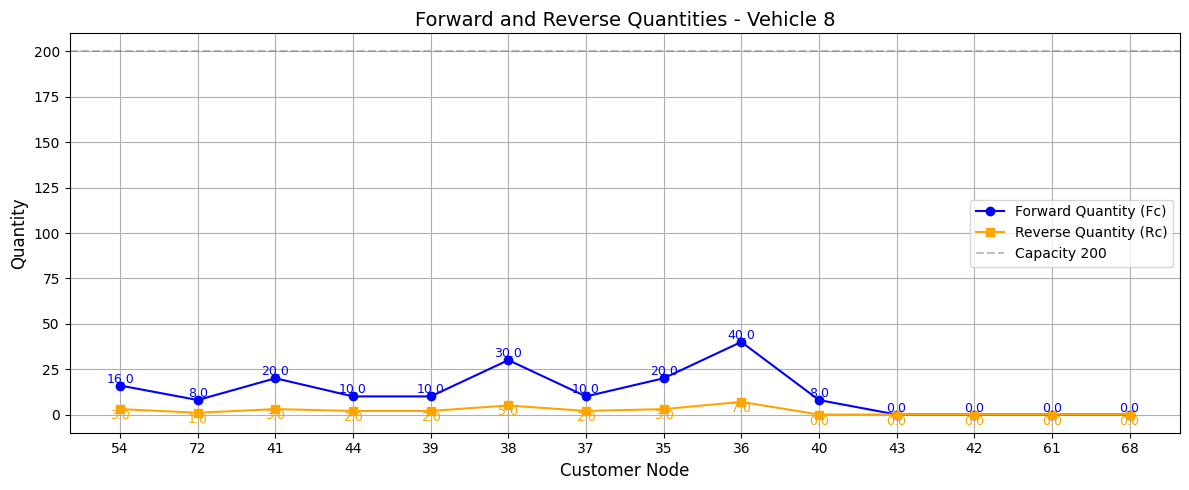

In [18]:
plot_forward_reverse_meta(lns_routes, dc, dc_rev, lambda_v)


In [19]:
def plot_objective_over_time(iterations, times):
    plt.figure(figsize=(12, 6))
    plt.plot(iterations, label="Objective Value")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Value")
    plt.title("Objective Value Progress Over Iterations")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(times, iterations, label="Objective vs Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Objective Value")
    plt.title("Objective Value vs Time")
    plt.grid(True)
    plt.legend()
    plt.show()


Iter 0: Best cost = 1605014.67, Temp = 995.00
Iter 100: Best cost = 343068.50, Temp = 602.74
Iter 200: Best cost = 283808.55, Temp = 365.12
Iter 300: Best cost = 227681.22, Temp = 221.18
Iter 400: Best cost = 198298.81, Temp = 133.98
Iter 500: Best cost = 183522.43, Temp = 81.16
Iter 600: Best cost = 176404.67, Temp = 49.17
Iter 700: Best cost = 176404.67, Temp = 29.78
Iter 800: Best cost = 176404.67, Temp = 18.04
Iter 900: Best cost = 176404.67, Temp = 10.93


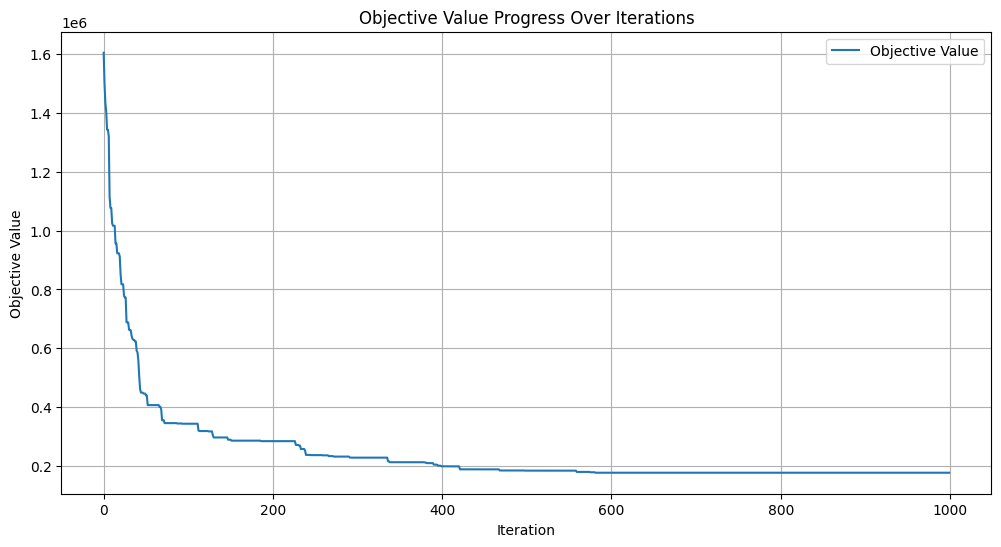

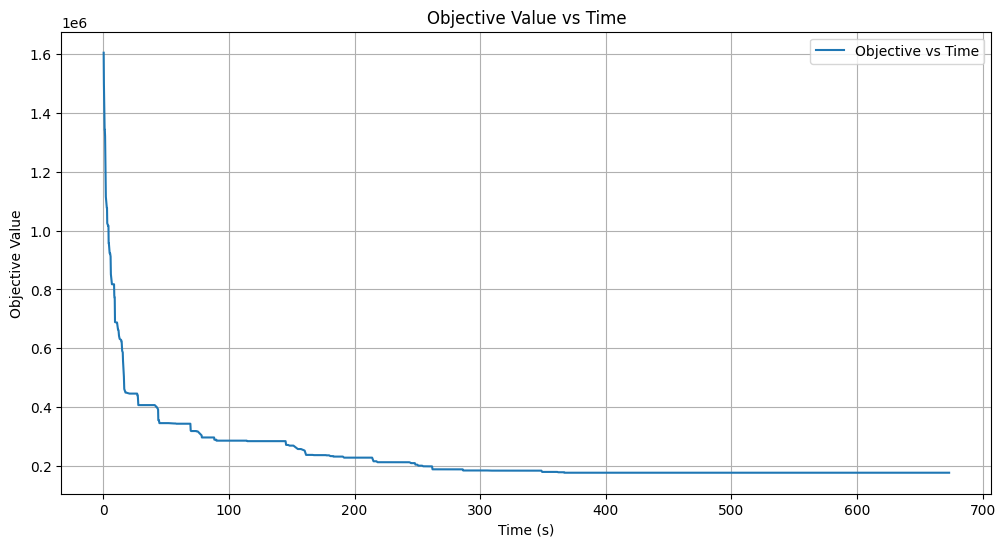

In [20]:
lns_routes, lns_cost, obj_history, time_history = ialns_sa(
    initial_routes, evaluate_with_penalty, destruction_ops, repair_ops
)

plot_objective_over_time(obj_history, time_history)
